In [1]:
import torch

In [2]:
import pandas as pd

In [3]:
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm

In [4]:
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
# torch.manual_seed(42)

In [5]:
import mlflow.pytorch

In [6]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.11.0
Cuda available: True
Torch geometric version: 2.0.4


## Dataset Creation

https://github.com/quarkslab/dataset-call-graph-blogpost-material

https://colab.research.google.com/drive/17JFlnMUjcsMmXQYXF8xZ3z169VDAwUls?authuser=1

https://www.youtube.com/watch?v=QLIkOtKS4os&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=9

https://github.com/deepfindr/gnn-project

In [7]:
# test_dataset = MoleculeDataset(root="data/", filename="HIV_test.csv", test=True)

In [8]:
import pickle
path_temp= "dataset-call-graph-blogpost-material/dataset/"

In [9]:
good_data=pickle.load(open(path_temp+"goodware_graphs.p","rb"))
bad_data=pickle.load(open(path_temp+"malware_graphs.p","rb"))

In [10]:
print("length of array = ",len(good_data))
print("length of 1 item = ",len(good_data[0]))
print("length of first thing in one item = ",len(good_data[0][0]))
print("length of second thing in one item = ",len(good_data[0][1]))

length of array =  546
length of 1 item =  2
length of first thing in one item =  464
length of second thing in one item =  464


In [11]:
node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

In [12]:

class MoleculeDataset(Dataset):
    def __init__(self, root, filename,good_data, bad_data, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.good_data=good_data
        self.bad_data=bad_data
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        self.data_passed=self.good_data+self.bad_data
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return ["goodware_graphs.p","malware_graphs.p"]

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
#         self.data = self.data_passed
        return "NOt implemented yet"

        # if self.test:
        #     return [f'data_test_{i}.pt' for i in list(self.data.index)]
        # else:
        #     return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
#         self.data = self.data_passed
        print("started doing stuff")
        index=0

        for mol in (self.good_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 1

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        for mol in (self.bad_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 0

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        

    def process_node_features(self,val, node_feature_menu):
      # print("jj")
      # print(val)
      node_out=[]
      keys=val.keys()
      for name in node_feature_menu : 
        if(name in keys):
          node_out.append(val[name])
        else:
          node_out.append(0)
      return node_out


    def _get_node_features(self, node_features,instr_index):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

        all_node_feats = []

        for atom in node_features:
            # print("atom is",atom)
            
            node_feats = []
            node_feats = self.process_node_features(node_features[atom],node_feature_menu)
            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        # for bond in mol.GetBonds():
        #     edge_feats = []
        #     # Feature 1: Bond type (as double)
        #     edge_feats.append(bond.GetBondTypeAsDouble())
        #     # Feature 2: Rings
        #     edge_feats.append(bond.IsInRing())
        #     # Append node features to matrix (twice, per direction)
        #     all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def get_one_instr_adjacency(self,val,instr_index,self_instruction_number):
        edge_val=[]
        for a in val:
            edge_val+=[[instr_index[self_instruction_number],instr_index[a]]]

        return edge_val

    def _get_adjacency_info(self, mol, instr_index):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol:
            edge_indices += self.get_one_instr_adjacency(mol[bond],instr_index,bond)

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
#         return self.data_pass.shape[0]
        return len(self.data_passed)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        data = torch.load(os.path.join(self.processed_dir, 
                             f'data_{idx}.pt'))
        return data





In [13]:
train_dataset = MoleculeDataset(root="data/", filename="goodware_graphs.p", good_data=good_data, bad_data=bad_data)

Processing...


started doing stuff


Done!


In [14]:
print(train_dataset[600])

Data(x=[1222, 27], edge_index=[2, 3265], edge_attr=[0], y=0, smiles=[2])


In [15]:
print(train_dataset[1].edge_index.t())

tensor([[  1, 437],
        [  2,   4],
        [  3, 412],
        ...,
        [491, 142],
        [491, 289],
        [491, 135]])


In [16]:
print(train_dataset[1].x)

tensor([[ 4.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [11.,  0.,  2.,  ...,  0.,  0.,  0.],
        [ 7.,  4.,  2.,  ...,  0.,  0.,  0.],
        [26., 10.,  0.,  ...,  0.,  0.,  0.]])


In [17]:
test_cut_dataset=train_dataset[526:566]
train_cut_dataset= train_dataset[:526]+train_dataset[566:]

In [84]:
from torch_geometric.data import DataLoader

#%% Prepare training
NUM_GRAPHS_PER_BATCH = 10
# NUM_GRAPHS_PER_BATCH = 1

train_loader = DataLoader(train_cut_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True,
                         num_workers=0)
# test_loader = DataLoader(test_dataset, 
#                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_cut_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


## MODEL

In [85]:
import torch
import torch.nn.functional as F 
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv
# torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        num_classes = 2
        embedding_size = 1024

        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)

        # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024, num_classes)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # First block
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)

        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Second block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Third block
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Concat pooled vectors
        x = x1 + x2 + x3

        # Output block
        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)

        return x


In [92]:
import torch 
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
# from dataset_featurizer import MoleculeDataset
# from model import GNN
import mlflow.pytorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)





In [87]:
# #%% Loss and Optimizer
# # new one 

# # weights = torch.tensor([1, 20], dtype=torch.float32).to(device)
# # loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# weight2 = torch.tensor([BEST_PARAMETERS["pos_weight"]], dtype=torch.float32).to(device)
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight2)

# optimizer = torch.optim.SGD(model.parameters(), lr=BEST_PARAMETERS['learning_rate'], momentum=BEST_PARAMETERS['sgd_momentum'], weight_decay=BEST_PARAMETERS["weight_decay"])  
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=BEST_PARAMETERS["scheduler_gamma"])


In [93]:
#%% Loading the model
model = GNN(feature_size=train_dataset[0].x.shape[1]) 
model = model.to(device)
print(f"Number of parameters: {count_parameters(model)}")
model

Number of parameters: 17945602


GNN(
  (conv1): GATConv(27, 1024, heads=3)
  (head_transform1): Linear(in_features=3072, out_features=1024, bias=True)
  (pool1): TopKPooling(1024, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(1024, 1024, heads=3)
  (head_transform2): Linear(in_features=3072, out_features=1024, bias=True)
  (pool2): TopKPooling(1024, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(1024, 1024, heads=3)
  (head_transform3): Linear(in_features=3072, out_features=1024, bias=True)
  (pool3): TopKPooling(1024, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

In [94]:
#%% Loss and Optimizer
# original
weights = torch.tensor([1, 3], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)  
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


In [95]:
optimizer.zero_grad()        
# loss, hidden = model(data, hidden, targets)
# loss.backward()
clip_value=10
torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
optimizer.step()

In [96]:
def test(epoch):
    all_preds = []
    all_labels = []
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss = torch.sqrt(loss_fn(pred, batch.y))    
        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "test")
    return loss


def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_pred, y_true)}")
    print(f"Accuracy: {accuracy_score(y_pred, y_true)}")
    print(f"Precision: {precision_score(y_pred, y_true)}")
    print(f"Recall: {recall_score(y_pred, y_true)}")
    try:
        roc = roc_auc_score(y_pred, y_true)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")
        
    try:
        mlflow.log_metric(key=f"accuracy-{type}", value=float(accuracy_score(y_pred, y_true)), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"Accuracy: notdefined")

In [97]:

def train(epoch):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients

        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                                batch.edge_attr.float(),
                                batch.edge_index, 
                                batch.batch) 
        # Calculating the loss and gradients
#         loss = torch.sqrt(loss_fn(pred, batch.y)) 
        loss_v1 = loss_fn(pred, batch.y) 
        loss_v2=torch.sqrt(loss_v1)
#         print("batch.y")
#         print(batch.y)
        
#         print("pred")
#         print(pred)
        
#         print("loss_v1")
#         print(loss_v1)
#         print("loss_v2")
#         print(loss_v2)
        
        loss=loss_v2
        loss.backward()  
        # Update using the gradients
        optimizer.step()  

        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return loss




In [98]:

# %% Run the training
with mlflow.start_run() as run:
    for epoch in range(50):
        # Training
        model.train()
        loss = train(epoch=epoch)
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Train Loss {loss}")
        mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

        # Testing
        model.eval()
        if epoch % 5 == 0:
            loss = test(epoch=epoch)
            loss = loss.detach().cpu().numpy()
            print(f"Epoch {epoch} | Test Loss {loss}")
            mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)

        scheduler.step()
print("Done.")



  3%|▎         | 4/133 [00:40<21:44, 10.12s/it]


RuntimeError: CUDA out of memory. Tried to allocate 268.00 MiB (GPU 0; 4.00 GiB total capacity; 1.89 GiB already allocated; 0 bytes free; 2.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# # cuda run out of space problem
# import gc
# del variables
# gc.collect()

NameError: name 'variables' is not defined

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [55]:

# %% Save the model 
mlflow.pytorch.log_model(model, "model") 

2022/04/23 15:31:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\JERRYJ~1\AppData\Local\Temp\tmp5sdh5yz_\model\data, flavor: pytorch), fall back to return ['torch==1.11.0', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.
D:\Anaconda3\envs\pytorch\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


ModelInfo(artifact_path='model', flavors={'pytorch': {'model_data': 'data', 'pytorch_version': '1.11.0', 'code': None}, 'python_function': {'pickle_module_name': 'mlflow.pytorch.pickle_module', 'loader_module': 'mlflow.pytorch', 'python_version': '3.9.12', 'data': 'data', 'env': 'conda.yaml'}}, model_uri='runs:/cc21dc71c0534040841e16dbca0e94bc/model', model_uuid='0b947a31a40446c39570297bbf4897d7', run_id='cc21dc71c0534040841e16dbca0e94bc', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-04-23 10:00:57.036793', mlflow_version='1.25.1')

Confusion Matrix

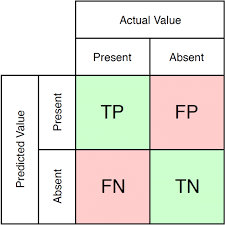

In [43]:
model_type_name="findr_gcn_model1"

In [49]:
from datetime import date
from datetime import datetime


In [69]:
# SAVE MODEL
#  pls create a folder named model_saved if not there
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y %H_%M_%S")
PATH_to_save_model="model_saved/"+"model_"+dt_string+":"+model_type_name+".pt"
PATH_to_save_model="model_saved/model "+dt_string+".pt"
torch.save(model, PATH_to_save_model)

In [68]:
# # Model class must be defined somewhere
# model2 = torch.load(PATH_to_save_model)
# model2.eval()

GNN(
  (conv1): GATConv(27, 27, heads=3)
  (head_transform1): Linear(in_features=81, out_features=27, bias=True)
  (pool1): TopKPooling(27, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(27, 27, heads=3)
  (head_transform2): Linear(in_features=81, out_features=27, bias=True)
  (pool2): TopKPooling(27, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(27, 27, heads=3)
  (head_transform3): Linear(in_features=81, out_features=27, bias=True)
  (pool3): TopKPooling(27, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=54, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

# Model 2

In [42]:
import torch
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(GNN, self).__init__()
        embedding_size = model_params["model_embedding_size"]
        n_heads = model_params["model_attention_heads"]
        self.n_layers = model_params["model_layers"]
        dropout_rate = model_params["model_dropout_rate"]
        top_k_ratio = model_params["model_top_k_ratio"]
        # self.top_k_every_n = model_params["model_top_k_every_n"]
        self.top_k_every_n = 1
        dense_neurons = model_params["model_dense_neurons"]
        edge_dim = model_params["model_edge_dim"]

        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])

        # Transformation layer
        self.conv1 = TransformerConv(feature_size, 
                                    embedding_size, 
                                    heads=n_heads, 
                                    dropout=dropout_rate,
                                    edge_dim=edge_dim,
                                    beta=True) 

        self.transf1 = Linear(embedding_size*n_heads, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)

        # Other layers
        for i in range(self.n_layers):
            self.conv_layers.append(TransformerConv(embedding_size, 
                                                    embedding_size, 
                                                    heads=n_heads, 
                                                    dropout=dropout_rate,
                                                    edge_dim=edge_dim,
                                                    beta=True))

            self.transf_layers.append(Linear(embedding_size*n_heads, embedding_size))
            self.bn_layers.append(BatchNorm1d(embedding_size))
            
            # this is me doing shit
            # print(self.top_k_every_n)
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(TopKPooling(embedding_size, ratio=top_k_ratio))
            

        # Linear layers
        self.linear1 = Linear(embedding_size*2, dense_neurons)
        self.linear2 = Linear(dense_neurons, int(dense_neurons/2))  
        self.linear3 = Linear(int(dense_neurons/2), 1)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Initial transformation
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(self.transf1(x))
        x = self.bn1(x)

        # Holds the intermediate graph representations
        global_representation = []

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index, edge_attr)
            x = torch.relu(self.transf_layers[i](x))
            x = self.bn_layers[i](x)
            # Always aggregate last layer
            if i % self.top_k_every_n == 0 or i == self.n_layers:
                x , edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[int(i/self.top_k_every_n)](
                    x, edge_index, edge_attr, batch_index
                    )
                # Add current representation
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))
    
        x = sum(global_representation)

        # Output block
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = self.linear3(x)

        return x



In [69]:
#%% imports 
import torch 
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import mlflow.pytorch
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Specify tracking server
mlflow.set_tracking_uri("http://localhost:5000")



def count_parameters(model):
    # for pp in model.parameters():
    #     print("------------")
    #     print(pp==null)
    #     print(pp)
    #     print(pp.requires_grad)
    #     print(pp.numel())
    #     print("------------")


    # return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return 1


def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                                batch.edge_attr.float(),
                                batch.edge_index, 
                                batch.batch) 
        # Calculating the loss and gradients
        loss = loss_fn(torch.squeeze(pred), batch.y.float())
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return running_loss/step

def test(epoch, model, test_loader, loss_fn):
    all_preds = []
    all_preds_raw = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss = loss_fn(torch.squeeze(pred), batch.y.float())

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_preds_raw.append(torch.sigmoid(pred).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    print(all_preds_raw[0][:10])
    print(all_preds[:10])
    print(all_labels[:10])
    calculate_metrics(all_preds, all_labels, epoch, "test")
    log_conf_matrix(all_preds, all_labels, epoch)
    return running_loss/step

def log_conf_matrix(y_pred, y_true, epoch):
    # Log confusion matrix as image
    cm = confusion_matrix(y_pred, y_true)
    classes = ["0", "1"]
    df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
    cfm_plot.figure.savefig(f'data/images/cm_{epoch}.png')
    mlflow.log_artifact(f"data/images/cm_{epoch}.png")

def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_pred, y_true)}")
    print(f"Accuracy: {accuracy_score(y_pred, y_true)}")
    prec = precision_score(y_pred, y_true)
    rec = recall_score(y_pred, y_true)
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    mlflow.log_metric(key=f"Precision-{type}", value=float(prec), step=epoch)
    mlflow.log_metric(key=f"Recall-{type}", value=float(rec), step=epoch)
    try:
        roc = roc_auc_score(y_pred, y_true)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")


In [70]:
# from mango import scheduler, Tuner

# # Search space
# param_space = dict(x=range(-10,10))

# # Quadratic objective Function
# @scheduler.serial
# def objective(x):
#     return x * x

# # Initialize and run Tuner
# tuner = Tuner(param_space, objective)
# results = tuner.minimize()

# print(f'Optimal value of parameters: {results["best_params"]} and objective: {results["best_objective"]}')
# # => Optimal value of parameters: {'x': 0}  and objective: 0

In [71]:
# %% Run the training
from mango import scheduler, Tuner
from config import HYPERPARAMETERS, BEST_PARAMETERS, SIGNATURE

In [72]:



def run_one_training(params):
    params = params[0]
    with mlflow.start_run() as run:
        # Log parameters used in this experiment
        for key in params.keys():
            mlflow.log_param(key, params[key])

        # Loading the dataset
        print("Loading dataset...")
        train_dataset = MoleculeDataset(root="data/", filename="goodware_graphs.p", good_data=good_data, bad_data=bad_data)
        test_cut_dataset=train_dataset[526:566]
        train_cut_dataset= train_dataset[:526]+train_dataset[566:]

        # params["model_edge_dim"] = train_dataset[0].edge_attr.shape[1]
        params["model_edge_dim"] = 0

        # Prepare training
        train_loader = DataLoader(test_cut_dataset, batch_size=params["batch_size"], shuffle=True)
        test_loader = DataLoader(train_cut_dataset, batch_size=params["batch_size"], shuffle=True)

        # Loading the model
        print("Loading model...")
        model_params = {k: v for k, v in params.items() if k.startswith("model_")}
        print("printing init mdoel params")
        for par in model_params:
            print(par)
        model = GNN(feature_size=train_dataset[0].x.shape[1], model_params=model_params) 
        model = model.to(device)
        print(f"Number of parameters: {count_parameters(model)}")
        mlflow.log_param("num_params", count_parameters(model))

        # < 1 increases precision, > 1 recall
        weight = torch.tensor([params["pos_weight"]], dtype=torch.float32).to(device)
        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
        optimizer = torch.optim.SGD(model.parameters(), 
                                    lr=params["learning_rate"],
                                    momentum=params["sgd_momentum"],
                                    weight_decay=params["weight_decay"])
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params["scheduler_gamma"])
        
        # Start training
        best_loss = 1000
        early_stopping_counter = 0
        for epoch in range(300): 
            if early_stopping_counter <= 10: # = x * 5 
                # Training
                model.train()
                loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
                print(f"Epoch {epoch} | Train Loss {loss}")
                mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

                # Testing
                model.eval()
                if epoch % 5 == 0:
                    loss = test(epoch, model, test_loader, loss_fn)
                    print(f"Epoch {epoch} | Test Loss {loss}")
                    mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)
                    
                    # Update best loss
                    if float(loss) < best_loss:
                        best_loss = loss
                        # Save the currently best model 
                        mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1

                scheduler.step()
            else:
                print("Early stopping due to no improvement.")
                return [best_loss]
    print(f"Finishing training with best test loss: {best_loss}")
    return [best_loss]


In [73]:

# %% Hyperparameter search
print("Running hyperparameter search...")
config = dict()
config["optimizer"] = "Bayesian"
config["num_iteration"] = 100

tuner = Tuner(HYPERPARAMETERS, 
              objective=run_one_training,
              conf_dict=config) 
results = tuner.minimize()

Running hyperparameter search...
Loading dataset...
started doing stuff


Processing...
Done!


Loading model...
printing init mdoel params
model_top_k_ratio
model_top_k_every_n
model_layers
model_embedding_size
model_dropout_rate
model_dense_neurons
model_attention_heads
model_edge_dim
1
1
1
Number of parameters: 1


  0%|          | 0/1 [00:32<?, ?it/s]


IndexError: The shape of the mask [82452] at index 0 does not match the shape of the indexed tensor [0] at index 0

In [51]:
config = dict()
config["optimizer"] = "Bayesian"
config["num_iteration"] = 100

In [68]:
x=3
x==None


False

In [50]:
for p in model2.parameters():
    print(p)

NameError: name 'model2' is not defined

In [25]:
5%0

ZeroDivisionError: integer division or modulo by zero

# Model 3 : Sage

* https://medium.com/analytics-vidhya/ohmygraphs-graphsage-in-pyg-598b5ec77e7b
* https://towardsdatascience.com/introduction-to-graphsage-in-python-a9e7f9ecf9d7


In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]


In [83]:

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [77]:
data_planets=data

In [80]:
data=train_dataset
data=train_cut_dataset

In [82]:
data=data_planets